In [8]:
!pwd

/data/volume_2/work_beyond_clicks


In [9]:
# https://examples.dask.org/machine-learning.html
# https://ml.dask.org/
# https://medium.com/analytics-vidhya/dask-for-python-and-machine-learning-dbe1356b5d7a
# https://www.manifold.ai/dask-and-machine-learning-preprocessing-tutorial
import os 
os.environ["DASK_TEMPORARY_DIRECTORY"] = "tmp"
if not os.path.exists("tmp"):
    os.mkdir("tmp")

import pandas as pd
import json
import tqdm

import dask
import hvplot.dask
import hvplot.pandas
import dask.dataframe as dd
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import panel as pn
pn.extension(comms="vscode")

In [10]:
print("Load Data")
DATA_FOLDER = "preflight"
ddf_views = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_views.csv', dtype={'GEO_ZIPCODE': object,
        'REFR_MEDIUM': object, 
        'IS_LOGGED_IN': object, 
        'file_name': object,
        'ARTICLE_ID':"str",
       })
ddf_views["article_id"] = ddf_views["ARTICLE_ID"]
ddf_views = ddf_views.drop(["ARTICLE_ID"] , axis=1)
ddf_views["DERIVED_TSTAMP"] = dd.to_datetime(ddf_views["DERIVED_TSTAMP"])
ddf_views["hour"] = ddf_views["DERIVED_TSTAMP"].dt.hour
ddf_views["weekday"] = ddf_views["DERIVED_TSTAMP"].dt.weekday
ddf_views["dayofmonth"] = ddf_views["DERIVED_TSTAMP"].dt.day
ddf_views["month"] = ddf_views["DERIVED_TSTAMP"].dt.month
ddf_views = ddf_views.replace("nu.web.advertorial", "nu.web")
ddf_views_unidentified = ddf_views[ddf_views["QUASI_USER_ID"].isna()].copy()
ddf_views = ddf_views[~ddf_views["QUASI_USER_ID"].isna()]
ddf_views = ddf_views.set_index('article_id')
device_counts = ddf_views["APP_ID"].value_counts().compute()
# sample_amount = (device_counts.min()//100000)*100000
sample_amount = device_counts.min()
# sample_amount = 1000000
unique_devices = device_counts.index.unique()
columns_privacy = list(ddf_views.columns[ddf_views.columns.str.startswith("privacy_")].values)
columns_time = ["hour", "weekday", "dayofmonth", "month"]


Load Data


In [11]:
ddf_views = ddf_views.groupby('APP_ID').apply(lambda df: df.sample(sample_amount if len(df) else 0) , meta=ddf_views.partitions[0])
ddf_views

,APP_ID,DERIVED_TSTAMP,GEO_CITY,GEO_COUNTRY,GEO_REGION,GEO_ZIPCODE,REFR_MEDIUM,REFR_URLHOST,QUASI_USER_ID,IS_LOGGED_IN,privacy_functional,privacy_analytics,privacy_target_advertising,privacy_personalisation,privacy_non-personalised_ads,privacy_marketing,privacy_social_media,privacy_geo_location,privacy_advertising,file_name,hour,weekday,dayofmonth,month
npartitions=3,,,,,,,,,,,,,,,,,,,,,,,,
,object,datetime64[ns],int64,object,object,object,object,int64,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [12]:
DATA_FOLDER_ARTICLES = "reduced"
ddf_articles = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_article.csv', dtype={
    'sub_section': 'object',
    'url': 'object', 
    'article_id':"str"
    })
ddf_articles = ddf_articles.set_index('article_id')
ddf_articles.head().T

article_id,1013291,1149251,1401797,1420717,1505884
cds_content_id,article-mm-6239e222e28ee500012c67ff,article-mm-6229c559c1fdac00016a6b3e,article-mm-626a799867ff2a00019c059e,article-mm-625813d6bd1e1f0001e11f21,article-mm-626a5ea882b43e0001ba6fb0
brands,nu.nl,nu.nl,nu.nl,nu.nl,nu.nl
title,De Peugeot 207 SW!,Meer details nieuwe Opel Agila,Oranje meest populair voor Dodge Charger,Nieuwe Celica in samenwerking met Subaru,Waar komt de Volkswagen Up vandaan?
text,In de Peugeot-vestiging in Poissy is de voorse...,De beelden die we eerder al liet zien toonden ...,Dodge heeft onlangs de Charger nieuw leven ing...,In Japan wordt gepraat over een opvolger van d...,Het Tsjechische Vrchlabi en het Spaanse Pamplo...
authors,autoweek.nl,autoweek.nl,autoweek.nl,autoweek.nl,autoweek.nl
url,https://nu.nl/auto/1013291/de-peugeot-207-sw.html,https://nu.nl/auto/1149251/meer-details-nieuwe...,https://nu.nl/auto/1401797/oranje-meest-popula...,https://nu.nl/auto/1420717/nieuwe-celica-in-sa...,https://nu.nl/auto/1505884/waar-komt-de-volksw...
main_section,Onderweg,Onderweg,Economie,Onderweg,Onderweg
sub_section,NaN,NaN,Onderweg,NaN,NaN
num_words,170,361,178,206,152
num_sentences,17,27,20,20,17


In [13]:
ddf_userneeds = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_userneeds.csv', dtype={
    'sub_section': 'object',
    'url': 'object', 
    'article_id':"str"
    })
columns_userneeds = list(ddf_userneeds.columns[ddf_userneeds.columns.str.startswith("userneed_")].values)
ddf_userneeds = ddf_userneeds.assign(argmax_userneeds = ddf_userneeds[columns_userneeds].idxmax(axis=1))
ddf_userneeds = ddf_userneeds.set_index('article_id')
ddf_userneeds.head().T

article_id,1013291,1149251,1401797,1420717,1505884
userneed_hou_me_op_de_hoogte,0.132751,0.159672,0.071099,0.393687,0.14906
userneed_geef_me_context,0.059254,0.108233,0.054092,0.159692,0.400487
userneed_vermaak_me,0.704135,0.444364,0.790514,0.321118,0.137633
userneed_raak_me_verbind_me,0.089935,0.015201,0.059013,0.030522,0.304317
userneed_help_me,0.013925,0.272529,0.025282,0.094981,0.008503
file_name,2,3,3,3,3
argmax_userneeds,userneed_vermaak_me,userneed_vermaak_me,userneed_vermaak_me,userneed_hou_me_op_de_hoogte,userneed_geef_me_context


In [14]:
print("Running Merge")
merge_cols_view = ["APP_ID", "QUASI_USER_ID", "IS_LOGGED_IN", "GEO_REGION"]+columns_privacy+columns_time
merge_cols_article = ["main_section", "sub_section"]
merge_cols_drop = ['argmax_userneeds', 'file_name']
ddf_merged = ddf_userneeds.drop(merge_cols_drop, axis=1)
# ddf_merged = ddf_merged.merge(ddf_articles[merge_cols_article], how="inner", left_index=True, right_index=True)
ddf_merged = ddf_merged.merge(ddf_views[merge_cols_view], how="inner", left_index=True, right_index=True)
ddf_merged = ddf_merged.persist()
ddf_merged

Running Merge


,userneed_hou_me_op_de_hoogte,userneed_geef_me_context,userneed_vermaak_me,userneed_raak_me_verbind_me,userneed_help_me,APP_ID,QUASI_USER_ID,IS_LOGGED_IN,GEO_REGION,privacy_functional,privacy_analytics,privacy_target_advertising,privacy_personalisation,privacy_non-personalised_ads,privacy_marketing,privacy_social_media,privacy_geo_location,privacy_advertising,hour,weekday,dayofmonth,month
npartitions=3,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
from dask_ml.compose import ColumnTransformer
from dask_ml.preprocessing import Categorizer, DummyEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from dask_ml.cluster import KMeans, SpectralClustering
from dask_ml.decomposition import PCA, IncrementalPCA, TruncatedSVD

# col_categoricals = ["GEO_REGION", "APP_ID", "main_section", "sub_section", "IS_LOGGED_IN"]
col_categoricals = ["GEO_REGION", "APP_ID", "IS_LOGGED_IN"]
col_numericals = columns_userneeds + columns_time 
col_passed = columns_privacy 
col_dropped = ["QUASI_USER_ID"] 
prep_categoricals = make_pipeline(Categorizer(), DummyEncoder(drop_first=True), verbose=True)
prep_numericals = StandardScaler()

dim_reducer = IncrementalPCA(n_components=3)
estimator = KMeans()

col_transformer = ColumnTransformer([
    ("cat", prep_categoricals, col_categoricals),
    ("num", prep_numericals, col_numericals),
    ("dropped", 'drop', col_dropped),
    ("unchanged", 'passthrough', col_passed),
], n_jobs=4, preserve_dataframe=True, remainder='drop')
# col_transformer_1 = ColumnTransformer([
#     ("cat", prep_categoricals, col_categoricals),
#     # ("num", prep_numericals, col_numericals),
#     # ("dropped", 'drop', col_dropped),
#     # ("unchanged", 'passthrough', col_passed),
# ], n_jobs=4, preserve_dataframe=True, remainder='passthrough')
# col_transformer_2 = ColumnTransformer([
#     # ("cat", prep_categoricals, col_categoricals),
#     ("num", prep_numericals, col_numericals),
#     # ("dropped", 'drop', col_dropped),
#     # ("unchanged", 'passthrough', col_passed),
# ], n_jobs=4, preserve_dataframe=True, remainder='passthrough')
# col_transformer_3 = ColumnTransformer([
#     # ("cat", prep_categoricals, col_categoricals),
#     # ("num", prep_numericals, col_numericals),
#     # ("dropped", 'drop', col_dropped),
#     ("unchanged", 'passthrough', col_passed),
# ], n_jobs=4, preserve_dataframe=True, remainder='passthrough')
# estimators = [('reduce_dim', PCA(3)), ('cluster', KMeans())]



# pipe = make_pipeline(
#     col_transformer, 
#     # col_transformer_1, 
#     # col_transformer_2, 
#     # col_transformer_3, 
#     IncrementalPCA(n_components=10, svd_solver='auto'), 
#     # KMeans(),
#     verbose=True,
# )
# pipe = pipe.fit(ddf_merged)
# pipe

In [16]:
print("Running Clustering")
print("Step Transform")
ddf_transformed = col_transformer.fit_transform(ddf_merged).dropna().to_dask_array(lengths=True).rechunk()
ddf_transformed

Running Clustering
Step Transform
[Pipeline] ....... (step 1 of 2) Processing categorizer, total=   0.4s
[Pipeline] ...... (step 2 of 2) Processing dummyencoder, total=   0.0s


dask.array<rechunk-merge, shape=(1183085, 1028), dtype=float64, chunksize=(79890, 210), chunktype=numpy.ndarray>

In [17]:
print("Step Dimension Reduction")
ddf_reduced = dim_reducer.fit_transform(ddf_transformed) #.compute_chunk_sizes() #.compute_chunksizes(lengths=True)
ddf_reduced



Step Dimension Reduction


/opt/anaconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


dask.array<tensordot, shape=(1183085, 3), dtype=float64, chunksize=(79890, 3), chunktype=numpy.ndarray>

In [18]:
print("Step Clustering")
tmp_array_reduced = ddf_reduced.compute()
estimator = estimator.fit(tmp_array_reduced)
cluster_assignments = estimator.predict(tmp_array_reduced)
print("Done")
cluster_assignments

Step Clustering


: 

: 

In [ ]:

df_reduced = pd.DataFrame(ddf_reduced.compute()).assign(cluster=cluster_assignments.compute())
df_reduced
# pd.DataFrame(ddf_reduced.compute())
# cluster_assignments

,0,1,2,cluster
0,1.775245,2.093440,4.115187,1
1,-0.290810,-0.978574,0.069601,7
2,1.617679,-2.183724,0.568859,0
3,1.610026,-2.161016,0.369194,0
4,1.595655,-2.153040,0.407265,0
...,...,...,...,...
1186568,-1.731677,0.722054,-0.271183,3
1186569,-1.730607,0.739650,-0.328297,3
1186570,-1.729524,0.738663,-0.323475,3
1186571,-1.729664,0.738300,-0.323022,3


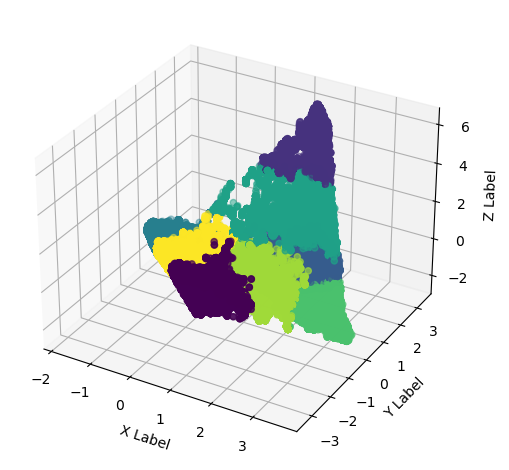

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_reduced[0],df_reduced[1],df_reduced[2],c=df_reduced["cluster"])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
fig.tight_layout()
plt.show()

In [ ]:
ddf_merged.compute().loc[(df_reduced["cluster"].values==0), :].T

article_id,4668651,4668651,4668651,4668651,4668651,4668651,4668651,4668651,4668651,4668651,...,6227172,6227172,6227172,6227172,6227172,6227172,6227172,6227172,6227172,6227172
userneed_hou_me_op_de_hoogte,0.024672,0.024672,0.024672,0.024672,0.024672,0.024672,0.024672,0.024672,0.024672,0.024672,...,0.236597,0.236597,0.236597,0.236597,0.236597,0.236597,0.236597,0.236597,0.236597,0.236597
userneed_geef_me_context,0.74862,0.74862,0.74862,0.74862,0.74862,0.74862,0.74862,0.74862,0.74862,0.74862,...,0.74107,0.74107,0.74107,0.74107,0.74107,0.74107,0.74107,0.74107,0.74107,0.74107
userneed_vermaak_me,0.066451,0.066451,0.066451,0.066451,0.066451,0.066451,0.066451,0.066451,0.066451,0.066451,...,0.010428,0.010428,0.010428,0.010428,0.010428,0.010428,0.010428,0.010428,0.010428,0.010428
userneed_raak_me_verbind_me,0.151833,0.151833,0.151833,0.151833,0.151833,0.151833,0.151833,0.151833,0.151833,0.151833,...,0.009931,0.009931,0.009931,0.009931,0.009931,0.009931,0.009931,0.009931,0.009931,0.009931
userneed_help_me,0.008423,0.008423,0.008423,0.008423,0.008423,0.008423,0.008423,0.008423,0.008423,0.008423,...,0.001974,0.001974,0.001974,0.001974,0.001974,0.001974,0.001974,0.001974,0.001974,0.001974
APP_ID,nu.web,nu.ios,nu.android,nu.android,nu.web,nu.web,nu.android,nu.ios,nu.web,nu.web,...,nu.android,nu.android,nu.android,nu.android,nu.ios,nu.android,nu.android,nu.android,nu.android,nu.android
QUASI_USER_ID,c9120197f3a778f5c9b1565af510dc74,b7c0b05a0194ba87570c6664d2ee31fb,c80331958a44457e75c0f777a029b696,885e9de802ed249f97dcfd7f9e1cb861,40bf1b96598f15a3eef1f8518f3421a7,7eef05e76cea5c4ea0f399a641bc0258,a49fc2ddcc34b32f32e7ec74abe7ee4a,653e0cf2bbc3f9b8007398d94638ac95,4a1753ddfbeaf7f062898e5a8fc3e99f,3e2970091a97bfe63c6e1007ce2963a7,...,70997e6b9a0ca2ce5b96389387bf8b6e,38900caa902c57c1e0af33efeb61493e,c51956cb43559c595e5837d8ec80db85,0c945d674405b38b9394ce5a067d657a,5946debf5c0d060a6a19289913632cb1,e2f3911a5263435907b031a13a9bc766,330e2ba5f7e9cbfa4364a083a759b750,bff62fc5a9acd499bab0687207bac254,32c91541a43ac5047868d011cbf665c1,a2a37459a41f2883fbe17b7b5541832e
IS_LOGGED_IN,1,0,0,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
GEO_REGION,GE,UT,NH,ZH,ZH,ZH,ZH,NB,NH,NH,...,61,FR,FR,GE,ZH,ZH,UT,NH,NB,NB
privacy_functional,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
ddf_merged.compute().loc[(df_reduced["cluster"].values==1), :].T

article_id,3972318,5850579,5850579,5936883,5936883,5936883,5936883,5936883,5936883,5936883,...,6226965,6226965,6226965,6226965,6226965,6226965,6226965,6226965,6226965,6227060
userneed_hou_me_op_de_hoogte,0.06387,0.007083,0.007083,0.008218,0.008218,0.008218,0.008218,0.008218,0.008218,0.008218,...,0.009366,0.009366,0.009366,0.009366,0.009366,0.009366,0.009366,0.009366,0.009366,0.008261
userneed_geef_me_context,0.015493,0.002955,0.002955,0.004511,0.004511,0.004511,0.004511,0.004511,0.004511,0.004511,...,0.002488,0.002488,0.002488,0.002488,0.002488,0.002488,0.002488,0.002488,0.002488,0.002431
userneed_vermaak_me,0.169852,0.0259,0.0259,0.093719,0.093719,0.093719,0.093719,0.093719,0.093719,0.093719,...,0.130461,0.130461,0.130461,0.130461,0.130461,0.130461,0.130461,0.130461,0.130461,0.056251
userneed_raak_me_verbind_me,0.009393,0.008224,0.008224,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,...,0.00854,0.00854,0.00854,0.00854,0.00854,0.00854,0.00854,0.00854,0.00854,0.004307
userneed_help_me,0.741392,0.955838,0.955838,0.887,0.887,0.887,0.887,0.887,0.887,0.887,...,0.849145,0.849145,0.849145,0.849145,0.849145,0.849145,0.849145,0.849145,0.849145,0.928751
APP_ID,nu.android,nu.web,nu.web,nu.web,nu.ios,nu.ios,nu.web,nu.web,nu.web,nu.android,...,nu.android,nu.ios,nu.android,nu.ios,nu.android,nu.android,nu.android,nu.android,nu.ios,nu.android
QUASI_USER_ID,56e155fb767501e6de09f508c85591cc,c70605f9615040864e7ac9af5a19eaa1,2de73262a0ea01bfa7146bacb3ea67cb,71cb8fa2cc71c9492f2794c5ee918472,cc0fcb61e16df914a0b5033cdd85f2c8,2facff42024485868003c0ba78ea6454,a2469dbcb654e94afb405e1cdd0c0bf5,1e836f7d86d6085278b840cb711e93c7,ba462b4bcac82666492620435addf457,89aa00254f44495098168db3e604c182,...,e1389bc19806bfcb76a3d4471a62931a,6387be03c7fa0b386394dd76e86d509b,497aaf23513a6ea22a889641ea61b483,2b323db84d3ffc7c95cb57dcb33fac1a,569acf101d5c7f9acff358a89ad8df61,864592a4e393a10f79012a8af9ed2a1c,ac5627ed64719568c8ffba28e90945da,6f3bf107da89b67f44b350ec2991a023,45e5bce25e3948969fe143aae31a76f6,23a875fd8ce4b8e90ea469c64d091b7a
IS_LOGGED_IN,0,1,1,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
GEO_REGION,ZH,VWV,VOV,NH,NB,GE,FL,UT,LI,LI,...,UT,UT,NH,GR,ZH,LI,NW,NH,NH,NB
privacy_functional,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
ddf_merged.compute().loc[(df_reduced["cluster"].values==2), :].T

article_id,5176715,5176715,5176715,5176715,5786598,5786598,6027388,6027388,6027388,6027388,...,6227184,6227184,6227184,6227184,6227184,6227184,6227184,6227184,6227184,6227184
userneed_hou_me_op_de_hoogte,0.016278,0.016278,0.016278,0.016278,0.006535,0.006535,0.011611,0.011611,0.011611,0.011611,...,0.16641,0.16641,0.16641,0.16641,0.16641,0.16641,0.16641,0.16641,0.16641,0.16641
userneed_geef_me_context,0.031764,0.031764,0.031764,0.031764,0.014855,0.014855,0.01644,0.01644,0.01644,0.01644,...,0.084761,0.084761,0.084761,0.084761,0.084761,0.084761,0.084761,0.084761,0.084761,0.084761
userneed_vermaak_me,0.754478,0.754478,0.754478,0.754478,0.821359,0.821359,0.695964,0.695964,0.695964,0.695964,...,0.659236,0.659236,0.659236,0.659236,0.659236,0.659236,0.659236,0.659236,0.659236,0.659236
userneed_raak_me_verbind_me,0.053114,0.053114,0.053114,0.053114,0.014273,0.014273,0.027112,0.027112,0.027112,0.027112,...,0.086705,0.086705,0.086705,0.086705,0.086705,0.086705,0.086705,0.086705,0.086705,0.086705
userneed_help_me,0.144366,0.144366,0.144366,0.144366,0.142978,0.142978,0.248872,0.248872,0.248872,0.248872,...,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889,0.002889
APP_ID,nu.web,nu.web,nu.web,nu.web,nu.web,nu.web,nu.web,nu.web,nu.android,nu.android,...,nu.android,nu.android,nu.ios,nu.android,nu.ios,nu.android,nu.android,nu.android,nu.android,nu.android
QUASI_USER_ID,b65c2e17cfbe6460e5b279282ef01f51,9ca811f696721478107e24b63224c1f7,6a4717ea886708cf222bae80e0cfc04f,a3bf1e4638de3982616b28a6e28f853c,34e6ada8dc0b5241558415595bd57aff,b27c7c1f8b442620e2ee27d463130d5b,ab1a0e322c6bf22c67fd78e6283caf34,c825a1a9c152a9b9ebca0e5adc1a0404,fd643b34a4c4e16ebf2b3393276f3631,fed885a1b49e1885f4dfcc513ca8170e,...,94a6699a7d756923a00ea3a1e4710986,6631c80e53c16800e36832d379cf22a0,6dbeea49e567c40b02c821931e675cc0,b05dac103c6e085be43aa5c599a07c4d,52ebfbf7d933bffeb0621ce614067980,d06b23698577dfbb2fc3b8b1786a52f7,94a48534b89fb795d50737a8ac8f4341,ef9f6f4f0fc11fc7e178548aabe2d787,5033edf0a45ee6411557ba1dddf3bec0,030c02802fe5ea6666830d0024b75874
IS_LOGGED_IN,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
GEO_REGION,NB,ZH,NH,GR,UT,ZH,91,ZH,GE,LI,...,GE,UT,06,GE,ZH,FL,NH,NH,VIC,GE
privacy_functional,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
